In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

tf.random.set_seed(777)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Original Data Set

In [3]:
data = pd.read_csv('winequality-red.csv')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [6]:
data = data.sample(frac=1,random_state = 777)
Y_value = data['quality'].unique()
for i in range(len(Y_value)):
    data[(data['quality'] == i+3)] = i 
data_ar = np.array(data)
x_data = data_ar[:,0:-1]
y_data = data_ar[:,[-1]]

print(x_data.shape)

print(y_data.shape)

(1599, 11)
(1599, 1)


In [7]:
XY_test=data_ar[int(len(data_ar)*0.8):,:]
np.savetxt("wine_XY_test.csv", XY_test,delimiter=",")

# Y_data - quality

2    681
3    638
4    199
1     53
5     18
0     10
Name: quality, dtype: int64

[3 2 1 4 5 0]
6


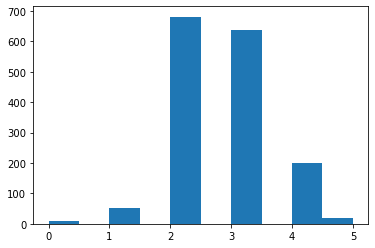

In [8]:
print(data['quality'].value_counts())
print()
Y_value = data['quality'].unique()
print(Y_value)

nb_classes = Y_value.shape[0]
print(nb_classes)

plt.hist(data['quality'])
plt.xticks([0,1,2,3,4,5])
plt.show()

In [9]:
print(y_data)


[[3.]
 [2.]
 [2.]
 ...
 [3.]
 [3.]
 [4.]]


# one_hot encoding

In [10]:
y_data_label=np.zeros((y_data.shape[0], 1))
# for i in range(y_data.shape[0]):
#     y_data_label[i][0] = y_data[i][0] - 3

#num = array_count_values(y_data_label)
print(y_data_label)
print(np.unique(y_data_label))

[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
[0.]


In [11]:
# Y_label = 3, 4, 5, 6, 7, 8

# Convert y_data to one_hot
Y_one_hot = tf.keras.utils.to_categorical(y_data, nb_classes)
print("one_hot: \n", Y_one_hot)

one_hot: 
 [[0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]]


# Train / Validation / Test  Data Set

In [12]:
X_train=x_data[:int(len(x_data)*0.6),:]
Y_train=Y_one_hot[:int(len(Y_one_hot)*0.6),:]

X_val=x_data[int(len(x_data)*0.6):int(len(x_data)*0.8),:]
Y_val=Y_one_hot[int(len(Y_one_hot)*0.6):int(len(Y_one_hot)*0.8),:]

X_test=x_data[int(len(x_data)*0.8):,:]
Y_test=Y_one_hot[int(len(Y_one_hot)*0.8):,:]

print(X_train.shape)
print(Y_train.shape)
print()
print(X_val.shape)
print(Y_val.shape)
print()
print(X_test.shape)
print(Y_test.shape)

(959, 11)
(959, 6)

(320, 11)
(320, 6)

(320, 11)
(320, 6)


# Scaler

In [13]:
# normalization

def MinMaxScaler_train(data):
    numerator = data - np.min(data,0)
    denominator = np.max(data,0) - np.min(data,0)
# 0으로 나누는 것을 방지
    return numerator / (denominator + 1e-7)

def MinMaxScaler_val_test(data, train_min, train_max):
    numerator = data - train_min
    denominator = train_max - train_min
# 0으로 나누는 것을 방지
    return numerator / (denominator + 1e-7)

trainx_norm = MinMaxScaler_train(X_train)

trainx_min = np.array(np.min(X_train,0))
trainx_max = np.array(np.max(X_train,0))

valx_norm = MinMaxScaler_val_test(X_val, trainx_min, trainx_max)
testx_norm = MinMaxScaler_val_test(X_test, trainx_min, trainx_max)

print(trainx_norm)

print(valx_norm)

print(testx_norm)

[[0.59999999 0.59999999 0.59999999 ... 0.59999999 0.59999999 0.59999999]
 [0.39999999 0.39999999 0.39999999 ... 0.39999999 0.39999999 0.39999999]
 [0.39999999 0.39999999 0.39999999 ... 0.39999999 0.39999999 0.39999999]
 ...
 [0.39999999 0.39999999 0.39999999 ... 0.39999999 0.39999999 0.39999999]
 [0.39999999 0.39999999 0.39999999 ... 0.39999999 0.39999999 0.39999999]
 [0.39999999 0.39999999 0.39999999 ... 0.39999999 0.39999999 0.39999999]]
[[0.39999999 0.39999999 0.39999999 ... 0.39999999 0.39999999 0.39999999]
 [0.59999999 0.59999999 0.59999999 ... 0.59999999 0.59999999 0.59999999]
 [0.39999999 0.39999999 0.39999999 ... 0.39999999 0.39999999 0.39999999]
 ...
 [0.2        0.2        0.2        ... 0.2        0.2        0.2       ]
 [0.39999999 0.39999999 0.39999999 ... 0.39999999 0.39999999 0.39999999]
 [0.59999999 0.59999999 0.59999999 ... 0.59999999 0.59999999 0.59999999]]
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.39999999 0.39999999 0.39999999 ... 

In [14]:
# Standrad Scaler
#from sklearn.preprocessing import StandardScaler

#scaler=StandardScaler()

#scaler.fit(x_train_set)
#X_train_norm=scaler.transform(x_train_set)

#scaler.fit(x_test_set)
#X_test_norm=scaler.transform(x_test_set)

#print(X_train_norm)
#print()
#print(X_test_norm)

# X data _ 3차원

In [18]:
X_train_3 = trainx_norm.reshape(trainx_norm.shape[0], trainx_norm.shape[1], 1)
X_val_3 = valx_norm.reshape(valx_norm.shape[0], valx_norm.shape[1], 1)
X_test_3 = testx_norm.reshape(testx_norm.shape[0], testx_norm.shape[1], 1)
print(X_train_3.shape)
print(X_val_3.shape)
print(X_test_3.shape)

(959, 11, 1)
(320, 11, 1)
(320, 11, 1)


# Model

In [22]:
# parameters
input_dim=(X_train_3.shape[1],X_train_3.shape[2])
output_dim=Y_train.shape[1]

# hyper poarameters
learning_rate=0.07
training_epochs=500
batch_size=50
drop_rate=0.3

tf.model=tf.keras.Sequential()
tf.model.add(tf.keras.layers.Conv1D(filters=40, kernel_size=6, input_shape=input_dim,strides=1,activation='elu'))
tf.model.add(tf.keras.layers.Dropout(drop_rate))
# L2
tf.model.add(tf.keras.layers.Conv1D(filters=40, kernel_size=2,strides=1, activation='elu'))
tf.model.add(tf.keras.layers.Dropout(drop_rate))
# L fully connected
tf.model.add(tf.keras.layers.Flatten())
tf.model.add(tf.keras.layers.Dense(units=50, activation='elu'))
tf.model.add(tf.keras.layers.Dropout(drop_rate))
tf.model.add(tf.keras.layers.Dense(units=output_dim, activation='softmax'))


tf.model.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(lr=0.001), metrics=['accuracy'])
tf.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 6, 40)             280       
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, 40)             0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 5, 40)             3240      
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 40)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)               

In [23]:
history = tf.model.fit(X_train_3, Y_train, epochs=training_epochs, batch_size=batch_size, validation_data=(X_val_3,Y_val))

Epoch 1/500
20/20 [==============================] - 1s 10ms/step - loss: 1.5853 - accuracy: 0.3228 - val_loss: 1.2016 - val_accuracy: 0.3688
Epoch 2/500
20/20 [==============================] - 0s 3ms/step - loss: 1.2469 - accuracy: 0.3949 - val_loss: 1.1294 - val_accuracy: 0.8250
Epoch 3/500
20/20 [==============================] - 0s 3ms/step - loss: 1.1541 - accuracy: 0.5233 - val_loss: 1.0562 - val_accuracy: 0.8250
Epoch 4/500
20/20 [==============================] - 0s 3ms/step - loss: 1.0789 - accuracy: 0.5531 - val_loss: 0.8944 - val_accuracy: 0.8250
Epoch 5/500
20/20 [==============================] - 0s 3ms/step - loss: 0.9133 - accuracy: 0.7300 - val_loss: 0.6623 - val_accuracy: 0.8250
Epoch 6/500
20/20 [==============================] - 0s 3ms/step - loss: 0.7049 - accuracy: 0.8183 - val_loss: 0.4789 - val_accuracy: 0.9469
Epoch 7/500
20/20 [==============================] - 0s 3ms/step - loss: 0.4936 - accuracy: 0.8791 - val_loss: 0.3184 - val_accuracy: 0.8250
Epoch 8/500


20/20 [==============================] - 0s 3ms/step - loss: 0.0125 - accuracy: 0.9978 - val_loss: 3.9420e-04 - val_accuracy: 1.0000
Epoch 59/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0056 - accuracy: 0.9990 - val_loss: 6.4866e-04 - val_accuracy: 1.0000
Epoch 60/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0260 - accuracy: 0.9933 - val_loss: 3.2607e-04 - val_accuracy: 1.0000
Epoch 61/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0071 - accuracy: 0.9972 - val_loss: 2.9681e-04 - val_accuracy: 1.0000
Epoch 62/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0068 - accuracy: 0.9999 - val_loss: 4.6189e-04 - val_accuracy: 1.0000
Epoch 63/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0087 - accuracy: 0.9960 - val_loss: 1.4829e-04 - val_accuracy: 1.0000
Epoch 64/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0061 - accuracy: 0.9992 - val_loss: 2.0223e-04 - val_accuracy

20/20 [==============================] - 0s 3ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.8625e-05 - val_accuracy: 1.0000
Epoch 115/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.3553e-05 - val_accuracy: 1.0000
Epoch 116/500
20/20 [==============================] - 0s 3ms/step - loss: 5.8904e-04 - accuracy: 1.0000 - val_loss: 8.0312e-06 - val_accuracy: 1.0000
Epoch 117/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 1.3959e-05 - val_accuracy: 1.0000
Epoch 118/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 7.0173e-06 - val_accuracy: 1.0000
Epoch 119/500
20/20 [==============================] - 0s 3ms/step - loss: 6.2877e-04 - accuracy: 1.0000 - val_loss: 8.1428e-06 - val_accuracy: 1.0000
Epoch 120/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0084 - accuracy: 0.9975 - val_loss: 1.3225e-05 

20/20 [==============================] - 0s 3ms/step - loss: 0.0025 - accuracy: 0.9990 - val_loss: 1.2849e-06 - val_accuracy: 1.0000
Epoch 170/500
20/20 [==============================] - 0s 3ms/step - loss: 5.6374e-04 - accuracy: 1.0000 - val_loss: 1.2908e-06 - val_accuracy: 1.0000
Epoch 171/500
20/20 [==============================] - 0s 3ms/step - loss: 2.3402e-04 - accuracy: 1.0000 - val_loss: 1.3493e-06 - val_accuracy: 1.0000
Epoch 172/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0029 - accuracy: 0.9997 - val_loss: 2.3004e-06 - val_accuracy: 1.0000
Epoch 173/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.0852e-04 - val_accuracy: 1.0000
Epoch 174/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0052 - accuracy: 0.9978 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 175/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 1.2791e-05 - va

Epoch 224/500
20/20 [==============================] - 0s 3ms/step - loss: 2.0318e-04 - accuracy: 0.9998 - val_loss: 6.7726e-07 - val_accuracy: 1.0000
Epoch 225/500
20/20 [==============================] - 0s 3ms/step - loss: 3.9837e-04 - accuracy: 1.0000 - val_loss: 2.4140e-07 - val_accuracy: 1.0000
Epoch 226/500
20/20 [==============================] - 0s 3ms/step - loss: 1.3727e-04 - accuracy: 1.0000 - val_loss: 1.7695e-07 - val_accuracy: 1.0000
Epoch 227/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0087 - accuracy: 0.9973 - val_loss: 1.2141e-05 - val_accuracy: 1.0000
Epoch 228/500
20/20 [==============================] - 0s 3ms/step - loss: 3.4632e-04 - accuracy: 1.0000 - val_loss: 4.8056e-08 - val_accuracy: 1.0000
Epoch 229/500
20/20 [==============================] - 0s 3ms/step - loss: 5.9970e-04 - accuracy: 1.0000 - val_loss: 3.3528e-08 - val_accuracy: 1.0000
Epoch 230/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0011 - accuracy: 0.99

20/20 [==============================] - 0s 3ms/step - loss: 5.7907e-05 - accuracy: 1.0000 - val_loss: 7.1153e-08 - val_accuracy: 1.0000
Epoch 279/500
20/20 [==============================] - 0s 3ms/step - loss: 2.2766e-04 - accuracy: 1.0000 - val_loss: 6.1095e-08 - val_accuracy: 1.0000
Epoch 280/500
20/20 [==============================] - 0s 3ms/step - loss: 2.5566e-04 - accuracy: 1.0000 - val_loss: 6.2212e-08 - val_accuracy: 1.0000
Epoch 281/500
20/20 [==============================] - 0s 3ms/step - loss: 8.4076e-05 - accuracy: 1.0000 - val_loss: 7.1153e-08 - val_accuracy: 1.0000
Epoch 282/500
20/20 [==============================] - 0s 3ms/step - loss: 3.2357e-05 - accuracy: 1.0000 - val_loss: 7.1153e-08 - val_accuracy: 1.0000
Epoch 283/500
20/20 [==============================] - 0s 3ms/step - loss: 1.2304e-04 - accuracy: 1.0000 - val_loss: 7.1153e-08 - val_accuracy: 1.0000
Epoch 284/500
20/20 [==============================] - 0s 3ms/step - loss: 9.1976e-05 - accuracy: 1.0000 - v

20/20 [==============================] - 0s 3ms/step - loss: 4.6750e-05 - accuracy: 1.0000 - val_loss: 8.1211e-08 - val_accuracy: 1.0000
Epoch 333/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0017 - accuracy: 0.9994 - val_loss: 3.1425e-06 - val_accuracy: 1.0000
Epoch 334/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0145 - accuracy: 0.9983 - val_loss: 1.1176e-08 - val_accuracy: 1.0000
Epoch 335/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0021 - accuracy: 0.9987 - val_loss: 9.2871e-07 - val_accuracy: 1.0000
Epoch 336/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0031 - accuracy: 0.9987 - val_loss: 1.3947e-06 - val_accuracy: 1.0000
Epoch 337/500
20/20 [==============================] - 0s 3ms/step - loss: 9.9909e-04 - accuracy: 0.9997 - val_loss: 5.5172e-07 - val_accuracy: 1.0000
Epoch 338/500
20/20 [==============================] - 0s 3ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.0027 - va

Epoch 387/500
20/20 [==============================] - 0s 3ms/step - loss: 1.1970e-04 - accuracy: 1.0000 - val_loss: 5.9977e-08 - val_accuracy: 1.0000
Epoch 388/500
20/20 [==============================] - 0s 3ms/step - loss: 1.4922e-05 - accuracy: 1.0000 - val_loss: 6.2212e-08 - val_accuracy: 1.0000
Epoch 389/500
20/20 [==============================] - 0s 3ms/step - loss: 6.2586e-04 - accuracy: 0.9997 - val_loss: 1.1250e-07 - val_accuracy: 1.0000
Epoch 390/500
20/20 [==============================] - 0s 3ms/step - loss: 2.2535e-04 - accuracy: 1.0000 - val_loss: 4.4666e-07 - val_accuracy: 1.0000
Epoch 391/500
20/20 [==============================] - 0s 3ms/step - loss: 1.6977e-04 - accuracy: 1.0000 - val_loss: 6.8918e-08 - val_accuracy: 1.0000
Epoch 392/500
20/20 [==============================] - 0s 3ms/step - loss: 3.0725e-05 - accuracy: 1.0000 - val_loss: 5.5507e-08 - val_accuracy: 1.0000
Epoch 393/500
20/20 [==============================] - 0s 3ms/step - loss: 8.7251e-05 - accura

20/20 [==============================] - 0s 3ms/step - loss: 4.9563e-04 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 442/500
20/20 [==============================] - 0s 3ms/step - loss: 8.0244e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 443/500
20/20 [==============================] - 0s 3ms/step - loss: 2.7530e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 444/500
20/20 [==============================] - 0s 3ms/step - loss: 3.8656e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 445/500
20/20 [==============================] - 0s 3ms/step - loss: 2.2378e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 446/500
20/20 [==============================] - 0s 3ms/step - loss: 1.9657e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 447/500
20/20 [==============================] - 0s 3ms/step - loss: 9.1293e-06 - accuracy: 1.0000 - v

20/20 [==============================] - 0s 3ms/step - loss: 2.3604e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 496/500
20/20 [==============================] - 0s 3ms/step - loss: 4.0758e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 497/500
20/20 [==============================] - 0s 3ms/step - loss: 2.4073e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 498/500
20/20 [==============================] - 0s 3ms/step - loss: 1.3158e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 499/500
20/20 [==============================] - 0s 3ms/step - loss: 5.4148e-05 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 500/500
20/20 [==============================] - 0s 3ms/step - loss: 8.7263e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [24]:
history.history

{'loss': [1.421580195426941,
  1.2131620645523071,
  1.149960994720459,
  1.0469975471496582,
  0.8482218384742737,
  0.6221461296081543,
  0.4551611840724945,
  0.3378160893917084,
  0.271091103553772,
  0.2158406376838684,
  0.1794290542602539,
  0.16726116836071014,
  0.15037983655929565,
  0.13792648911476135,
  0.14346714317798615,
  0.11608121544122696,
  0.11147033423185349,
  0.08967368304729462,
  0.10558860003948212,
  0.08276758342981339,
  0.08326365798711777,
  0.049346864223480225,
  0.08134550601243973,
  0.06097080931067467,
  0.04295605793595314,
  0.04368766024708748,
  0.06265844404697418,
  0.054343488067388535,
  0.057900432497262955,
  0.04571926221251488,
  0.05555087700486183,
  0.03874128311872482,
  0.04915400221943855,
  0.04571973532438278,
  0.031296610832214355,
  0.02836182899773121,
  0.034642208367586136,
  0.018018478527665138,
  0.0331995002925396,
  0.02363080531358719,
  0.022206813097000122,
  0.018443088978528976,
  0.0266941599547863,
  0.0114991

In [25]:
val_results = tf.model.evaluate(X_val_3, Y_val)
print('val accuracy: ', val_results[1])
print(val_results)

10/10 [==============================] - 0s 776us/step - loss: 0.0000e+00 - accuracy: 1.0000
val accuracy:  1.0
[0.0, 1.0]


In [26]:
Y_predicted =tf.model.predict_classes(X_test_3)
print(Y_predicted)
np.savetxt("wine_CNN-1D_1_relu_testYorigin.csv", y_data_label[int(len(y_data_label)*0.8):,:], delimiter=",")
np.savetxt("wine_CNN-1D_1_relu_testYpre.csv", Y_predicted, delimiter=",")

[0 2 3 3 5 2 3 3 4 3 3 3 3 3 2 3 4 3 3 3 3 3 4 3 3 1 2 2 3 4 2 2 3 2 3 2 4
 2 3 2 2 4 3 3 2 2 3 4 3 1 5 1 3 2 2 3 4 3 2 4 3 2 3 3 2 3 3 3 2 4 3 3 3 2
 3 2 4 2 2 2 2 2 4 3 2 3 2 3 4 3 2 2 2 3 2 2 2 2 3 2 4 2 4 2 2 3 3 3 3 3 3
 3 3 2 3 3 4 2 2 2 3 2 3 1 2 4 3 3 2 4 3 2 2 2 2 3 3 1 2 3 2 4 3 2 4 4 1 4
 5 2 2 2 2 3 1 3 3 3 4 2 4 3 2 3 3 3 2 3 3 3 2 3 4 4 3 2 3 2 3 3 1 3 2 3 2
 4 2 3 2 2 3 3 3 2 3 2 2 2 3 3 3 4 4 2 2 2 3 3 3 2 3 3 3 2 2 2 3 3 2 2 2 2
 2 3 3 3 3 2 4 2 3 3 2 3 3 2 2 2 3 3 2 2 2 2 3 2 2 3 2 3 4 2 3 4 3 3 3 4 4
 5 4 3 4 3 4 2 3 3 3 2 2 2 4 3 4 2 3 2 3 3 4 2 3 3 5 2 1 4 3 4 3 3 2 4 2 2
 2 3 3 3 3 2 2 4 3 2 3 2 2 2 2 2 1 2 2 1 2 3 3 4]


C:\Users\USER\Anaconda3\envs\tensorflow_gpu_v2\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
test_results = tf.model.evaluate(X_test_3, Y_test)
print(test_results)

# Graph

In [ ]:
# loss
plt.figure(figsize=(12,4))
plt.plot(history.history['loss'], 'r-', label='loss')
plt.plot(history.history['val_loss'], 'b--', label='val_loss')
plt.xlabel('Epoch')
plt.xlim(1,training_epochs)
plt.ylim(0,2)
plt.legend()
plt.grid()
plt.show()

# accuracy
plt.figure(figsize=(12,4))
plt.plot(history.history['accuracy'],'r-', label='train_acc')
plt.plot(history.history['val_accuracy'],'b--', label='val_acc')
plt.xlabel('Epoch')
plt.xlim(1,training_epochs)
plt.ylim(0,1.1)
plt.legend()
plt.grid()
plt.show()